# Facebook comment analysis via Dynamic topic model

In this notebook file, we will infer dynamics of topics via the dynamic topic model (DTM). We will use two python packages `pandas` and `gensim`. `gensim` package provides a useful wrapper of the original DTM code. To run the DTM, you should have precompiled binary of the original code and put `DTM_HOME` environmental variable to indicate the location of the precompiled binary file.

- DTM reference: http://icml.cc/2016/awards/dtm.pdf
- DTM original source (c++): http://www.cs.columbia.edu/~blei/topicmodeling_software.html

Useful links:

- `gensim` dtm wrapper: https://radimrehurek.com/gensim/models/dtmmodel.html
- how dtm works in `gensim` wrapper: https://github.com/RaRe-Technologies/gensim/blob/0.12.4/docs/notebooks/dtm_example.ipynb

Note:
- `DTMModel` class in `gensim` is not compatable with python3. Should run the following code with python2

In [1]:
import os
from time import time
import cPickle
from collections import defaultdict

import numpy as np
import pandas as pd

import gensim
from gensim import corpora, utils
from gensim.corpora.dictionary import Dictionary
from gensim.models.wrappers.dtmmodel import DtmModel

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import matplotlib
import matplotlib.pyplot as plt

from dateutil import parser
import datetime

%matplotlib inline

Predefined functions

In [2]:
#date_series = pd.Series([parser.parse(date) for date in map(lambda x:x[:-5], df.postTimestamp)])
def dateparser(date_str):
    try:
        date = parser.parse(date_str).replace(tzinfo=None)
    except:
        date = datetime.datetime.now().replace(tzinfo=None)

    return date

### Load dataset

In [3]:
pagename = 'RageAgainstVaccines'
if pagename.startswith('Rage'):
    dataset = '../data/2013-12-28_to_2016-04-14_%s_FacebookData.csv' % pagename
else:
    dataset = '../data/2013-04-14_to_2016-04-14_%s_FacebookData.csv' % pagename

df = pd.read_csv(dataset, parse_dates=[6], date_parser=dateparser)

### Select comments

In [4]:
sorted_df = df.sort_values(by=['postTimestamp'])
df_comments = sorted_df.ix[(sorted_df['edgeType'] == 'Comment')]
text = list(df_comments['commentText'])
times = list(df_comments['postTimestamp'])
comments_text = [comment for comment in text if type(comment) == str]
comments_time = [times[i] for i, comment in enumerate(text) if type(comment) == str]

### Make a bag-of-word representation of documents

In [5]:
max_df = 0.90 # ignore terms that have a document frequency strictly higher than the given threshold
min_df = 2 # ignore terms that have a document frequency strictly lower than the given threshold

tf_vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, stop_words='english')
tf = tf_vectorizer.fit_transform(comments_text)

### Construct a corpus used in Gensim

In [6]:
corpus = gensim.matutils.Sparse2Corpus(tf.T)
n_terms, n_docs = corpus.sparse.shape
id2word = {i:word for i, word in enumerate(tf_vectorizer.get_feature_names())}
dictionary = Dictionary.from_corpus(corpus, id2word=id2word)

# Dynamic topic model

### Divide comments by posting time

In [7]:
n_time = 10
time_seq = [dictionary.num_docs/n_time] * n_time
time_seq[-1] += dictionary.num_docs - sum(time_seq)
cum_time = np.cumsum(time_seq)

### Configure dynamic topic model

In [8]:
# path to dtm home folder
dtm_home = os.environ.get('DTM_HOME', "dtm-master")
# path to the binary. on my PC the executable file is dtm-master/bin/dtm
dtm_path = os.path.join(dtm_home, 'bin', 'dtm') if dtm_home else None

# num topics
n_topics=20
alpha=0.01
top_chain_var=0.005
n_time = 10

# destination for result
dst = "../result/dtm/%s/" % (pagename)
if not os.path.exists(dst):
    os.makedirs(dst)
filename = "maxdf_%.2f_mindf_%.2f_topic_%d_equal_%d_alpha_%.3f_var_%.3f.model" % (max_df, min_df, n_topics, n_time, alpha, top_chain_var)

### Train dynamic topic model

In [9]:
if not os.path.exists(os.path.join(dst, filename)):
    tic = time()
    model = DtmModel(dtm_path, corpus, time_seq, num_topics=n_topics,
                     id2word=dictionary, initialize_lda=True, alpha=alpha, 
                     top_chain_var=top_chain_var, rng_seed=0)
    print(time()-tic)
    model.save(os.path.join(dst, filename))
else:
    model = DtmModel.load(os.path.join(dst, filename))

## Visualise top 10 words for each topic over time

Through the following visualisation, we can see how the probabilities of the first top 10 words change over time.

In [10]:
topics = defaultdict(list)
for k in range(n_topics):
    for ti in range(n_time):
        tmp = model.show_topic(topicid=k, time=ti, topn=n_terms)
        tmp_dict = {word:prob for (prob, word) in tmp}
        topics[k].append(tmp_dict)

In [11]:
def plot_tot(topicid=0, n_top=10, n_time=10):
    markers = matplotlib.markers.MarkerStyle.filled_markers
    topwords = [word for (prob,word) in model.show_topic(topicid=topicid, time=0, topn=n_top)]
    prob_table = np.zeros([n_time, n_top])

    for wi in range(n_top):
        for ti in range(n_time):
            prob_table[ti, wi] = topics[topicid][ti][topwords[wi]]
            
    plt.figure(figsize=(10,6))
    for wi in range(n_top):
        plt.plot(prob_table[:,wi], marker=markers[wi], label=topwords[wi])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('word probability')
    plt.xlabel('time')
    plt.xticks(range(n_time), [comments_time[cum_time[i]-1].strftime('%d-%m-%Y') for i in range(n_time)], rotation='vertical')
    plt.title('Topic over time, tid = %d' % (topicid))
    plt.show()

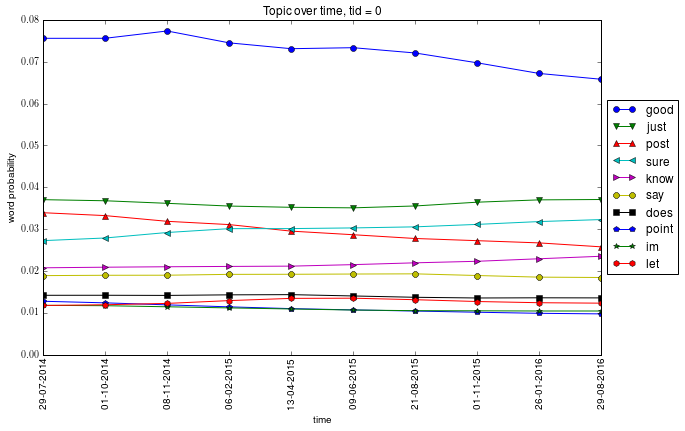

In [12]:
plot_tot(topicid=0, n_top=10, n_time=n_time)

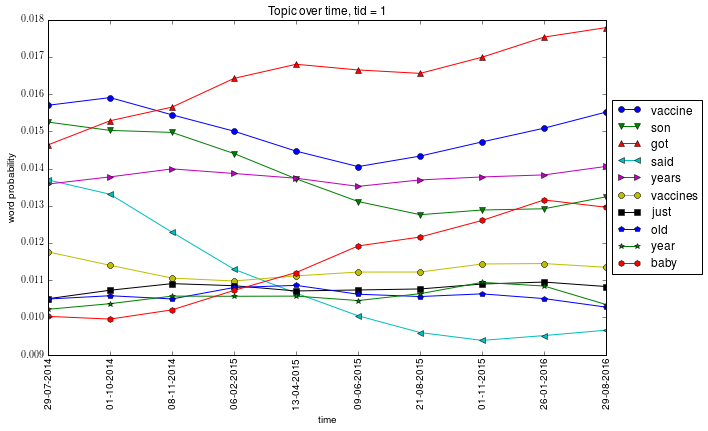

In [13]:
plot_tot(topicid=1, n_top=10, n_time=n_time)

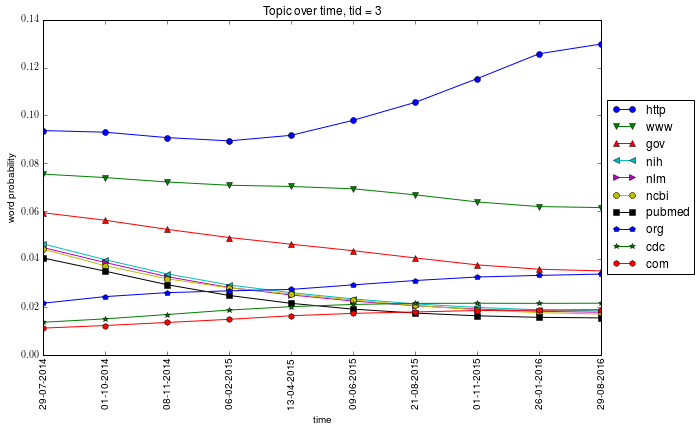

In [14]:
plot_tot(topicid=3, n_top=10, n_time=n_time)

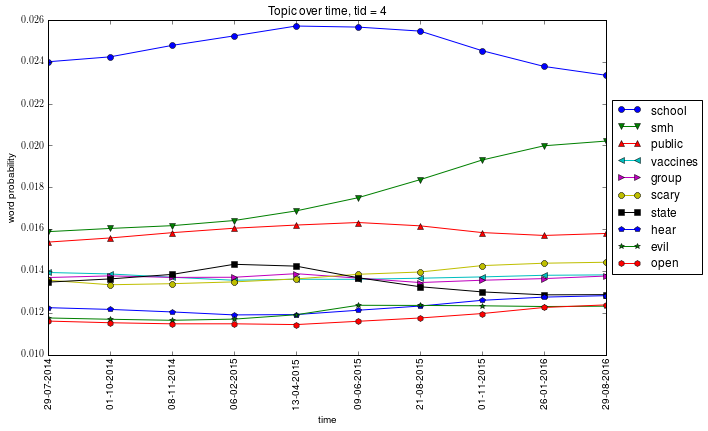

In [15]:
plot_tot(topicid=4, n_top=10, n_time=n_time)